<a href="https://colab.research.google.com/github/TamarSdeChen/Self-Learner-DeepLearning-Course-Technion/blob/main/BYOL_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.0/633.0 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 59.7 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=e81a8d93594748b95e6b4a191d27d83ab01182bc58f0396f32dd23453b3108ab
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [17]:
#import

import copy
import time
import os
import torch
import torchvision
from torch import nn



from matplotlib import pyplot as plt
import numpy as np
from google.colab import files


from torchvision.datasets import STL10
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.utils.scheduler import cosine_schedule

In [3]:
class BYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()
    self.backbone = backbone # e.g., resnet - REPRESENTATION
    self.projection_head = BYOLProjectionHead(512, 1024, 256)
    self.prediction_head = BYOLPredictionHead(256, 1024, 256)
    self.backbone_momentum = copy.deepcopy(self.backbone)
    self.projection_head_momentum = copy.deepcopy(self.projection_head)
    deactivate_requires_grad(self.backbone_momentum)
    deactivate_requires_grad(self.projection_head_momentum)

  def forward(self, x):
    y = self.backbone(x).flatten(start_dim=1)
    z = self.projection_head(y)
    p = self.prediction_head(z)
    return p
  def forward_momentum(self, x):
    y = self.backbone_momentum(x).flatten(start_dim=1)
    z = self.projection_head_momentum(y)
    z = z.detach()
    return z

In [4]:
class BYOL_FC(nn.Module):
  def __init__(self, representation_size, hidden_size, num_clases,num_init_w):
        super(BYOL_FC, self).__init__()
        self.linear1 = nn.Linear(representation_size, hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_size, num_clases)
        #self.linear3 = nn.Linear(hidden_size, num_clases)
        self.init_weights(num_init_w)

  def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # no softmax in the end when using crossentropy loss

        return out

  def init_weights(self, num_init_w):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        if (num_init_w == 0):
          #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          nn.init.xavier_uniform_(m.weight)
        else:
          nn.init.normal_(m.weight, 0, 0.005)


In [9]:
# if using the pre-trained beckbone: your input = True else False
pre_trained = input()
if pre_trained == "True":
  path_to_weights = 'pre_trained_backbone_BYOL_checkpoint.pth'
else:
  path_to_weights = 'BYOL_checkpoint.pth'

False


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialization for BYOL
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

state = torch.load(path_to_weights)
model.load_state_dict(state['net'])
model.to(device)
trained_BYOL_backbone = model.backbone

# create an instance of the MLP
learned_predictor_MLP = BYOL_FC(representation_size=512, hidden_size=128, num_clases=10, num_init_w=0).to(device)


# Define the combined model - this is the classifier
class CombinedModel(nn.Module):
  def __init__(self, backbone, mlp):
    super(CombinedModel, self).__init__()
    self.backbone = backbone
    self.mlp = mlp

  def forward(self, x):
    #
    x = self.backbone(x).flatten(start_dim=1)
    #
    x = self.mlp(x)
    return x

combined_model = CombinedModel(trained_BYOL_backbone, learned_predictor_MLP)


In [13]:
# time to train our combined model

# hyper-parameters
learning_rate = 1e-5
num_epochs = 200

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)


In [14]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with vlaues [0, 1]
])

train_labeled_dataset = STL10(root="data", split="train", download=True, transform=transform_train)
train_labeled_loader = torch.utils.data.DataLoader(
    train_labeled_dataset,
    batch_size=256,
    shuffle=False,
)

Files already downloaded and verified


In [15]:
# trining the classifier model
avg_epoch_losses = []
combined_model.train() # change the mode to training, activating layers like DropOut and BatchNorm, if there are any
for epoch in range(num_epochs):

  total_loss = 0
  epoch_losses = []

  for batch, labels in train_labeled_loader:
    # send data to device
    batch = batch.to(device)
    labels = labels.to(device)
    # forward pass
    output = combined_model(batch) # same as model.forward(features)

    # loss
    loss = criterion(output, labels)
    total_loss += loss.detach()
    epoch_losses.append(loss.item())

    # backward pass
    optimizer.zero_grad() # clean the gradients from previous iteration
    loss.backward() # autograd backward to calculate gradients
    optimizer.step() # apply update to the weights
  if epoch % 10 == 0:
    avg_loss = total_loss / len(train_labeled_loader)
    avg_epoch_losses.append(avg_loss)

    log = "Epoch: {} | Loss: {:.4f}".format(epoch, avg_loss)
    print(log)



Epoch: 0 | Loss: 3.0347
Epoch: 10 | Loss: 1.7741
Epoch: 20 | Loss: 1.3323
Epoch: 30 | Loss: 1.1259
Epoch: 40 | Loss: 1.0129
Epoch: 50 | Loss: 0.9224
Epoch: 60 | Loss: 0.8855
Epoch: 70 | Loss: 0.8296
Epoch: 80 | Loss: 0.8084
Epoch: 90 | Loss: 0.7806
Epoch: 100 | Loss: 0.7607
Epoch: 110 | Loss: 0.7405
Epoch: 120 | Loss: 0.7298
Epoch: 130 | Loss: 0.7035
Epoch: 140 | Loss: 0.6948
Epoch: 150 | Loss: 0.6781
Epoch: 160 | Loss: 0.6799
Epoch: 170 | Loss: 0.6652
Epoch: 180 | Loss: 0.6584
Epoch: 190 | Loss: 0.6354


<function matplotlib.pyplot.show(close=None, block=None)>

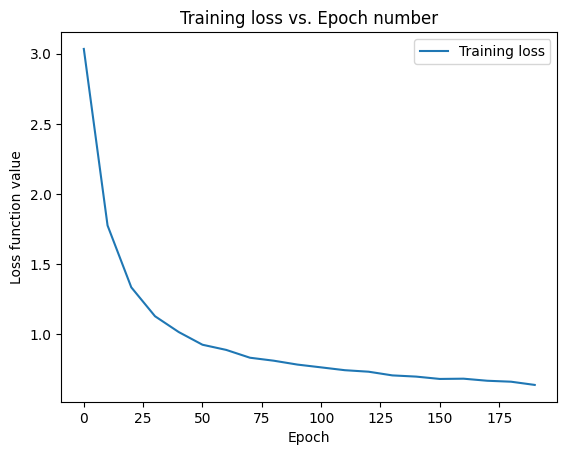

In [18]:
# print the training loss curve
epoch_num = np.arange(0, 200, 10, dtype=int)
plt.plot(epoch_num, torch.as_tensor(avg_epoch_losses).cpu(), label='Training loss')
plt.ylabel('Loss function value')
plt.xlabel('Epoch')
plt.title('Training loss vs. Epoch number')
plt.legend()
#plt.savefig("fine = Training loss.png")
#files.download("fine = Training loss.png")
plt.show

In [19]:
test_labeled_dataset = STL10(root="data", split="test", download=True, transform=ToTensor())
test_labeled_loader = torch.utils.data.DataLoader(
    test_labeled_dataset,
    batch_size=256,
    shuffle=False,
)


Files already downloaded and verified


In [20]:
# cheack the classification accuracy
def eval_BYOL_FC(model, dataloader, device=torch.device('cuda:0')):
  model.eval() # put in evaluation mode
  model_output = []
  labels = []
  num_samples = 0
  num_correct = 0
  with torch.no_grad():
    for data in dataloader:
      images, label = data
      images = images.to(device)
      label = label.to(device)
      output = model(images)
      model_output.append(output)
      labels.append(label.cpu())

      # values, index
      _, predictions = torch.max(output,1)
      num_samples += label.shape[0]
      num_correct += (predictions == label).sum().item()
    print(num_samples,num_correct)
    accuracy = 100.0 * (num_correct / num_samples)
    print('test accuracy = {}'.format(accuracy))
    model_output = torch.cat(model_output)
    labels = torch.cat(labels)

  return model_output.detach(), labels.detach()

In [21]:
model_output, labels = eval_BYOL_FC(combined_model, test_labeled_loader, device=device)

8000 6153
test accuracy = 76.9125
